In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
from sklearn import preprocessing
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import equalized_odds_difference
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource

import keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
# load dataset
import pandas as pd
from fairlearn.reductions import EqualizedOdds
import warnings
warnings.filterwarnings('ignore')

from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter import audit_report
from privacy_meter.audit_report import *
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import Fairlearn_Model, Sklearn_Model

In [3]:
from aif360.datasets import BinaryLabelDataset, StandardDataset
from data_utils import DatasetBuilder
from sklearn.metrics import auc, roc_auc_score

In [4]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import utils
from imblearn.over_sampling import ADASYN
import random
from aif360.metrics import BinaryLabelDatasetMetric

# load dataset

In [5]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

# # Step 2: Unzip the file
# !unzip bank-additional.zip -d bank-additional

# # Step 3: Move the contents to the required directory
# !mv bank-additional/bank-additional/* /usr/local/lib/python3.10/dist-packages/aif360/data/raw/bank/

# # Step 4: Remove the zip file
# !rm bank-additional.zip

In [6]:
DATASET = "bank"
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()

In [7]:
# Extract features (X) and labels (y) from the loaded dataset
X = dataset_orig.features
y_true = dataset_orig.labels.ravel()  # Flattening labels if needed

In [8]:
# Get sensitive attribute for analysis
sens_attr = dataset_orig.protected_attribute_names[0]  # 'age' is the protected attribute
sensitive_features = dataset_orig.features[:, dataset_orig.feature_names.index(sens_attr)]

In [9]:
# Normalize the features (similar to how it was done for `fetch_acs_income`)
X = preprocessing.normalize(X, norm='l2')

In [10]:
# Set up variables like they were in the original code
privileged_groups = dataset_builder.privileged_groups
unprivileged_groups = dataset_builder.unprivileged_groups

In [11]:
# Print the summary to verify data shapes and values
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y_true.shape}")
print(f"Sensitive attribute: {sens_attr} with values {np.unique(sensitive_features)}")
print(f"Privileged groups: {privileged_groups}, Unprivileged groups: {unprivileged_groups}")

Features shape: (25836, 57)
Labels shape: (25836,)
Sensitive attribute: age with values [0. 1.]
Privileged groups: [{'age': 1}], Unprivileged groups: [{'age': 0}]


# standard model

In [12]:
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=10)
classifier.fit(X, y_true)

y_pred = classifier.predict(X)
gm = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)
print(gm.overall)
print(gm.by_group)
print(equalized_odds_difference(y_true,
                                y_pred,
                                sensitive_features=sensitive_features))

0.9348970428858957
sensitive_feature_0
0.0    0.838384
1.0    0.939549
Name: accuracy_score, dtype: float64
0.05889563771446026


# fair models


In [13]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import equalized_odds_difference

# np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient
constraint = EqualizedOdds(difference_bound=0.0001)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sensitive_features)
y_pred_mitigated = mitigator.predict(X)
sr_mitigated = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sensitive_features)
print(sr_mitigated.overall)
print(sr_mitigated.by_group)

0.9064483666202199
sensitive_feature_0
0.0    0.782828
1.0    0.912407
Name: accuracy_score, dtype: float64


In [14]:
print(equalized_odds_difference(y_true,
                                y_pred_mitigated,
                                sensitive_features=sensitive_features))

0.0017313890563706302


# Attack models

In [15]:
# # for the population metric
# seed = 1234
# np.random.seed(seed)
# rng = np.random.default_rng(seed=seed) # useless

In [16]:
dataset_size = len(X)  # Should be 25836

In [17]:
dataset_size

25836

## Overlapping Indices Reference

In [18]:
# # # Determine split sizes proportionally (to sum up to the full dataset size)
# num_train_points = 5000
# num_test_points = 5000
# num_fair_train_points = 5000  # Reduced from 10000
# num_population_points = 10000  # Reduced from 30000

# train_index = np.random.choice(X.shape[0], num_train_points, replace=False)
# test_index = np.random.choice(X.shape[0], num_test_points, replace=False)
# fair_train_index = np.random.choice(X.shape[0], num_fair_train_points, replace=False)
# population_index = np.random.choice(X.shape[0], num_population_points, replace=False)

## Overlapping Indices Non-Reference

In [19]:
# # Determine split sizes proportionally (to sum up to the full dataset size)
# num_train_points = 12918  
# num_test_points = 12918 
# # num_fair_train_points = 5000  # Reduced from 10000
# # num_population_points = 10000  # Reduced from 30000

# train_index = np.random.choice(X.shape[0], num_train_points, replace=False)
# test_index = np.random.choice(X.shape[0], num_test_points, replace=False)
# # fair_train_index = np.random.choice(X.shape[0], num_fair_train_points, replace=False)
# population_index = train_index

## Unique Indices Reference

In [20]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = 3000
    num_test_points = 3000
#     num_fair_train_points = 5000  # Reduced from 10000
    num_population_points = 10000  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select fair train indices from the remaining indices without replacement
#     fair_train_index = np.random.choice(remaining_indices, num_fair_train_points, replace=False)
    # Remove fair train indices from available indices
#     remaining_indices = np.setdiff1d(remaining_indices, fair_train_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of fair train points: {len(fair_train_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [21]:
# # Determine split sizes proportionally (to sum up to the full dataset size)
# num_train_points = 3000
# num_test_points = 3000
# num_fair_train_points = 5000  # Reduced from 10000
# num_population_points = 10000  # Reduced from 30000

# # Start with all indices
# all_indices = np.arange(X.shape[0])

# # Select train indices without replacement
# train_index = np.random.choice(all_indices, num_train_points, replace=False)
# # Remove train indices from available indices
# remaining_indices = np.setdiff1d(all_indices, train_index)

# # Select test indices from the remaining indices without replacement
# test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
# # Remove test indices from available indices
# remaining_indices = np.setdiff1d(remaining_indices, test_index)

# # Select fair train indices from the remaining indices without replacement
# fair_train_index = np.random.choice(remaining_indices, num_fair_train_points, replace=False)
# # Remove fair train indices from available indices
# remaining_indices = np.setdiff1d(remaining_indices, fair_train_index)

# # Select population indices from the remaining indices (can also choose all remaining points)
# population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

# # Summary of counts
# print(f"Number of train points: {len(train_index)}")
# print(f"Number of test points: {len(test_index)}")
# print(f"Number of fair train points: {len(fair_train_index)}")
# print(f"Number of population points: {len(population_index)}")

## Unique Indices Non-Reference

In [22]:
# # Determine split sizes proportionally (to sum up to the full dataset size)
# num_train_points = 12918  
# num_test_points = 12918  
# # num_fair_train_points = 5000  # Reduced from 10000
# # num_population_points = 10000  # Reduced from 30000

# # Start with all indices
# all_indices = np.arange(X.shape[0])

# # Select train indices without replacement
# train_index = np.random.choice(all_indices, num_train_points, replace=False)
# # Remove train indices from available indices
# remaining_indices = np.setdiff1d(all_indices, train_index)

# # Select test indices from the remaining indices without replacement
# test_index = np.random.choice(remaining_indices, num_test_points, replace=False)

# # Select population indices from the remaining indices (can also choose all remaining points)
# population_index = train_index

# # Summary of counts
# print(f"Number of train points: {len(train_index)}")
# print(f"Number of test points: {len(test_index)}")
# print(f"Number of population points: {len(population_index)}")

In [23]:
# combined_indices = np.concatenate([population_index, test_index])
# assert len(combined_indices) == len(np.unique(combined_indices)), "Overlapping indices detected!"

In [24]:
# combined_indices = np.concatenate([train_index, test_index])
# assert len(combined_indices) == len(np.unique(combined_indices)), "Overlapping indices detected!"

In [25]:
# input_shape= X.shape[-1]
# num_classes= 1

In [26]:
# unique_values, counts = np.unique(y_true, return_counts=True)
# for value, count in zip(unique_values, counts):
#     print(f"Number of {value}s: {count}")

In [27]:
# unique_values, counts = np.unique(sensitive_features, return_counts=True)
# for value, count in zip(unique_values, counts):
#     print(f"Number of {value}s: {count}")

In [28]:
# result = (y_true[train_index])+ (sensitive_features[train_index] + 1) * 2
# unique_values, counts = np.unique(result, return_counts=True)
# for value, count in zip(unique_values, counts):
#     print(f"Number of {value}s: {count}")

In [29]:
# g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2
# g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
# g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

In [30]:
# # Check lengths before creating datasets
# assert len(train_index) == len(g_train), "Mismatch in train indices and group labels for train"
# assert len(test_index) == len(g_test), "Mismatch in test indices and group labels for test"
# assert len(population_index) == len(g_pop_train), "Mismatch in population indices and group labels for population"

In [31]:
# # Check dimensions before using boolean indexing
# print(f"g_train size: {g_train.shape}")
# print(f"g_test size: {g_test.shape}")
# print(f"g_test size: {g_pop_train.shape}")

In [32]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [33]:
# # create the target model's dataset
# train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
# test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
# target_dataset = Dataset(
#     data_dict={'train': train_ds, 'test': test_ds},
#     default_input='x', default_output='y', default_group='g'
# )

# # create the reference dataset
# population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
# reference_dataset = Dataset(
#     data_dict={'train': population_ds},
#     default_input='x', default_output='y', default_group='g'
# )

## Models

### Original

In [34]:
def log(y, pre):
    e = 0.0000001
    pre = np.clip(pre, e, 1 - e)
    return - y * np.log(pre) - (1 - y) * np.log(1 - pre)

In [35]:
def get_original_model(train_index, test_index):
    model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=10)
    model.fit(X[train_index], y_true[train_index])
    target_model = Sklearn_Model(model_obj=model, loss_fn=log)
    print(model)
    y_pred_test= model.predict(X[test_index])
    sr_test = MetricFrame(metrics=accuracy_score, y_true=y_true[test_index], y_pred=y_pred_test, sensitive_features=sensitive_features[test_index])
    y_pred_train= model.predict(X[train_index])
    sr_train = MetricFrame(metrics=accuracy_score, y_true=y_true[train_index], y_pred=y_pred_train, sensitive_features=sensitive_features[train_index])
    
    print("==============================================================")
    print("GET ORIGINAL MODEL")
    print(sr_test.overall, sr_test.by_group)
    print(sr_train.overall, sr_train.by_group)
    print(equalized_odds_difference(y_true[test_index],y_pred_test, sensitive_features=sensitive_features[test_index]))
    print("==============================================================")
    
    return target_model

### EG

In [36]:
def get_fair_model(train_index, test_index):
    constraint = EqualizedOdds(difference_bound=0.001)
    classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=10)
    mitigator = ExponentiatedGradient(classifier, constraint)
    mitigator.fit(X[train_index], y_true[train_index], sensitive_features=sensitive_features[train_index])
    fair_target_model = Fairlearn_Model(model_obj=mitigator, loss_fn=log)
    y_pred_test= mitigator.predict(X[test_index])
    sr_test = MetricFrame(metrics=accuracy_score, y_true=y_true[test_index], y_pred=y_pred_test, sensitive_features=sensitive_features[test_index])
    y_pred_train= mitigator.predict(X[train_index])
    sr_train = MetricFrame(metrics=accuracy_score, y_true=y_true[train_index], y_pred=y_pred_train, sensitive_features=sensitive_features[train_index])
    
    print("==============================================================")
    print("GET FAIR MODEL")
    print(sr_test.overall, sr_test.by_group)
    print(sr_train.overall, sr_train.by_group)
    print(equalized_odds_difference(y_true[test_index],y_pred_test, sensitive_features=sensitive_features[test_index]))
    print("==============================================================")
    
    return fair_target_model

### Syntethic

In [37]:
def balance(dataset, n_extra, inflate_rate, f_label, uf_label):

    # make a duplicate copy of the input data
    dataset_transf_train = dataset.copy(deepcopy=True)

    # subsets with favorable labels and unfavorable labels
    f_dataset = dataset.subset(np.where(dataset.labels==f_label)[0].tolist())
    uf_dataset = dataset.subset(np.where(dataset.labels==uf_label)[0].tolist())

    # expand the group with uf_label for oversampling purpose
    inflated_uf_features = np.repeat(uf_dataset.features, inflate_rate, axis=0)
    sample_features = np.concatenate((f_dataset.features, inflated_uf_features))
    inflated_uf_labels = np.repeat(uf_dataset.labels, inflate_rate, axis=0)
    sample_labels = np.concatenate((f_dataset.labels, inflated_uf_labels))
    

    # oversampling favorable samples
    # X: inflated dataset with synthetic samples of f_label attached to the end

    # Now apply ADASYN oversampling
    oversample = ADASYN(sampling_strategy='minority')
    X, y = oversample.fit_resample(sample_features, sample_labels)
    y = y.reshape(-1,1)

    # take samples from dataset with only favorable labels
    X = X[np.where(y==f_label)[0].tolist()]  # data with f_label + new samples
    y = y[y==f_label]

    selected = int(f_dataset.features.shape[0]+n_extra)

    X = X[:selected, :]
    y = y[:selected]
    y = y.reshape(-1,1)
    
    # print(f"Type of instance_weights: {type(f_dataset.instance_weights)}")
    # print(f"Shape of instance_weights: {getattr(f_dataset.instance_weights, 'shape', 'N/A')}")
    # print(f"Content of instance_weights: {f_dataset.instance_weights}")

    # print(f"Type of protected_attributes: {type(f_dataset.protected_attributes)}")
    # print(f"Shape of protected_attributes: {getattr(f_dataset.protected_attributes, 'shape', 'N/A')}")
    # print(f"Content of protected_attributes: {f_dataset.protected_attributes}")

    # Convert to lists if necessary
    instance_weights_list = f_dataset.instance_weights.flatten().tolist() if isinstance(f_dataset.instance_weights, np.ndarray) else f_dataset.instance_weights
    protected_attributes_list = f_dataset.protected_attributes.flatten().tolist() if isinstance(f_dataset.protected_attributes, np.ndarray) else f_dataset.protected_attributes

    # set weights and protected_attributes for the newly generated samples
    inc = X.shape[0]-f_dataset.features.shape[0]
    new_weights = [random.choice(instance_weights_list) for _ in range(inc)]
    new_attributes = [random.choice(protected_attributes_list) for _ in range(inc)]
    
    # new_attributes is 1D, reshape it to match the shape (n, 1)
    new_attributes = np.array(new_attributes).reshape(-1, 1)

    # compose transformed dataset
    dataset_transf_train.features = np.concatenate((uf_dataset.features, X))
    dataset_transf_train.labels = np.concatenate((uf_dataset.labels, y))
    dataset_transf_train.instance_weights = np.concatenate((uf_dataset.instance_weights, f_dataset.instance_weights, new_weights))
    dataset_transf_train.protected_attributes = np.concatenate((uf_dataset.protected_attributes, f_dataset.protected_attributes, new_attributes))

    # make a duplicate copy of the input data
    dataset_extra_train = dataset.copy()

    X_ex = X[-int(n_extra):]
    y_ex = y[-int(n_extra):]
    y_ex = y_ex.reshape(-1,1)
    
    # set weights and protected_attributes for the newly generated samples
    inc = int(n_extra)
    new_weights = [random.choice(instance_weights_list) for _ in range(inc)]
    new_attributes = [random.choice(protected_attributes_list) for _ in range(inc)]
    
    # new_attributes is 1D, reshape it to match the shape (n, 1)
    new_attributes = np.array(new_attributes).reshape(-1, 1)

    # compose extra dataset
    dataset_extra_train.features = X_ex
    dataset_extra_train.labels = y_ex
    dataset_extra_train.instance_weights = new_weights
    dataset_extra_train.protected_attributes = new_attributes

    # verifying
    #print(dataset_transf_train.features.shape)
    #print(dataset_transf_train.labels.shape)
    #print(dataset_transf_train.instance_weights.shape)
    #print(dataset_transf_train.protected_attributes.shape)

    # return favor and unfavored oversampling results
    return dataset_transf_train, dataset_extra_train

In [38]:
# return dataset indices of unprivileged and privileaged groups
def group_indices (dataset, unprivileged_groups):
    feature_names = dataset.feature_names
    cond_vec = utils.compute_boolean_conditioning_vector(dataset.features, feature_names, unprivileged_groups)

    # indices of examples in the unprivileged and privileged groups
    indices = [i for i, x in enumerate(cond_vec) if x == True]
    priv_indices = [i for i, x in enumerate(cond_vec) if x == False]
    return indices, priv_indices

In [39]:
# oversample favorable in the unprivileged group
def synthetic_favor_unpriv (dataset, unprivileged_groups, bp, bnp, f_label, uf_label, sampling_strategy=1.00):

    indices, priv_indices = group_indices (dataset, unprivileged_groups)

    # subset: unprivileged--unprivileged_dataset and privileged--privileged_dataset 
    unprivileged_dataset = dataset.subset(indices) # unprivileaged
    privileged_dataset = dataset.subset(priv_indices) # privilegaed

    n_unpriv_favor = np.count_nonzero(unprivileged_dataset.labels==f_label) # unprivileged with favorable label
    n_unpriv_unfavor = np.count_nonzero(unprivileged_dataset.labels!=f_label) # unprivileged with unfavorable label

    n_extra_sample = (bp * len(indices)-n_unpriv_favor) / (1- bp) * sampling_strategy
    # unprivileged favorable > unprivileged unfavorable
    if n_extra_sample + n_unpriv_favor >= n_unpriv_unfavor:
        inflate_rate = int(((n_extra_sample+n_unpriv_favor)/n_unpriv_unfavor)+1)
    else:
        inflate_rate = round(((n_extra_sample+n_unpriv_favor)/n_unpriv_unfavor)+1)

    dataset_transf_refprivileged_train, extra_favored_unpriv  = balance(unprivileged_dataset, n_extra_sample, inflate_rate, f_label, uf_label)

    return dataset_transf_refprivileged_train, extra_favored_unpriv

In [40]:
# adaptive oversampling for the unprivileged group
def synthetic(dataset, unprivileged_groups, bp, bnp, f_label, uf_label, os_mode=2, sampling_strategy=0.50):

    # make a duplicate copy of the input data
    dataset_transf_train = dataset.copy(deepcopy=True)

    # Case 1: privileged group is not relatively favored but has more favored in absolute number than the unprivileged group
    # if privileged base rate is less than unprivilegeted base rate
    if bp < bnp:
        dataset_transf_train = synthetic_balance(dataset, unprivileged_groups, bp, bnp, f_label, uf_label)
        return dataset_transf_train

    # Case 2: if privileged is favored, i.e. has a higher base rate

    # [Method 1] inflate privileged unfavored class
    if os_mode == 1: # if privileged is very low
        _, sample_unfavor_priv = synthetic_unfavor_priv (dataset, unprivileged_groups, bp, bnp, f_label, uf_label, sampling_strategy=1.00)
        dataset_transf_train.features = np.concatenate((dataset_transf_train.features, sample_unfavor_priv.features))
        dataset_transf_train.labels = np.concatenate((dataset_transf_train.labels, sample_unfavor_priv.labels))
        dataset_transf_train.instance_weights = np.concatenate((dataset_transf_train.instance_weights, sample_unfavor_priv.instance_weights))
        dataset_transf_train.protected_attributes = np.concatenate((dataset_transf_train.protected_attributes, sample_unfavor_priv.protected_attributes))
    elif os_mode == 2:
    # [Method 2] inflate unprivileged favored class
        _, sample_favor_unpriv = synthetic_favor_unpriv (dataset, unprivileged_groups, bp, bnp, f_label, uf_label, sampling_strategy=1.0)
        dataset_transf_train.features = np.concatenate((dataset_transf_train.features, sample_favor_unpriv.features))
        dataset_transf_train.labels = np.concatenate((dataset_transf_train.labels, sample_favor_unpriv.labels))
        dataset_transf_train.instance_weights = np.concatenate((dataset_transf_train.instance_weights, sample_favor_unpriv.instance_weights))
        dataset_transf_train.protected_attributes = np.concatenate((dataset_transf_train.protected_attributes, sample_favor_unpriv.protected_attributes))
    # [Method 3] combine methods 1 and 2 
    elif os_mode == 3:
        _, sample_unfavor_priv = synthetic_unfavor_priv (dataset, unprivileged_groups, bp, bnp, f_label, uf_label, sampling_strategy=1.00)
        dataset_transf_train.features = np.concatenate((dataset_transf_train.features, sample_unfavor_priv.features))
        dataset_transf_train.labels = np.concatenate((dataset_transf_train.labels, sample_unfavor_priv.labels))
        dataset_transf_train.instance_weights = np.concatenate((dataset_transf_train.instance_weights, sample_unfavor_priv.instance_weights))
        dataset_transf_train.protected_attributes = np.concatenate((dataset_transf_train.protected_attributes, sample_unfavor_priv.protected_attributes))
        _, sample_favor_unpriv = synthetic_favor_unpriv (dataset, unprivileged_groups, bp, bnp, f_label, uf_label, sampling_strategy=1.00)
        dataset_transf_train.features = np.concatenate((dataset_transf_train.features, sample_favor_unpriv.features))
        dataset_transf_train.labels = np.concatenate((dataset_transf_train.labels, sample_favor_unpriv.labels))
        dataset_transf_train.instance_weights = np.concatenate((dataset_transf_train.instance_weights, sample_favor_unpriv.instance_weights))
        dataset_transf_train.protected_attributes = np.concatenate((dataset_transf_train.protected_attributes, sample_favor_unpriv.protected_attributes))
    else:
        sys.exit("Oversampling mode is missing: 1: oversample unfavorable privileged; 2: oversample favorable unprivileged; 3. both")

    return dataset_transf_train

In [41]:
class BaseMitigator:

    def __init__(self):
        pass

    def run_mitigator(self):
        pass

In [42]:
class SyntheticMitigator(BaseMitigator):
    mitigator_type = 'Synthetic Data Mitigator'
    
    def run_mitigator (self, dataset_orig_train, dataset_orig_val, dataset_orig_test, 
                       privileged_groups, unprivileged_groups, 
                       base_rate_privileged, base_rate_unprivileged, 
                       f_label, uf_label, OS_MODE):
        # generating synthetic data
        dataset_transf_train = synthetic(dataset_orig_train, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, f_label, uf_label, os_mode = OS_MODE)
        print('origin, transf: ', dataset_orig_train.features.shape[0], dataset_transf_train.features.shape[0])

        metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
        print('after transf priv: ', metric_transf_train.base_rate(privileged=True))
        print('after transf unpriv: ', metric_transf_train.base_rate(privileged=False))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

        # fitting the model on the transformed dataset with synthetic generator
        dataset = dataset_transf_train

        return dataset

In [43]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     df[sens_attr_name] = sensitive_features
    

    print(df.head())
    print(dataset_orig.feature_names)
    print(dataset_orig.features.shape)
    
    df_orig, _ = dataset_orig.convert_to_dataframe()

    # Display the first few rows
    print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # Print the value counts
    for label, count in zip(unique_labels, counts):
        print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    print(dataset.feature_names)
    print(dataset.features.shape)
    # Get the unique labels and their counts
    unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    for label, count in zip(unique_labels, counts):
        print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [44]:
def get_syn_model(train_index, test_index, target_dataset):
    synth_mitigator = SyntheticMitigator()

    privileged_value = [1]  # Example: '1' indicates privileged (e.g., age >= 25)
    unprivileged_value = [0]  # Example: '0' indicates unprivileged (e.g., age < 25)
    
    # Convert train dataset
    dataset_orig_train = create_binary_label_dataset(
        dataset_orig=dataset_orig,
        X=X[train_index],
        y=y_true[train_index],
        sensitive_features=sensitive_features[train_index],
        sens_attr_name=sens_attr,
        privileged_value=privileged_value,
        unprivileged_value=unprivileged_value
    )
    
    # Convert test dataset
    dataset_orig_val = create_binary_label_dataset(
        dataset_orig=dataset_orig,
        X=X[test_index],
        y=y_true[test_index],
        sensitive_features=sensitive_features[test_index],
        sens_attr_name=sens_attr,
        privileged_value=privileged_value,
        unprivileged_value=unprivileged_value
    )
    
    # Since validation and testing datasets are the same
    dataset_orig_test = dataset_orig_val
    
    train_data = target_dataset.data_dict["train"]

    y_train = train_data['y']  # Labels
    g_train = train_data['g']  # Sensitive attribute

    # Separate privileged and unprivileged group indices
    priv_indices = (g_train == 4) | (g_train == 5)
    unpriv_indices = (g_train == 2) | (g_train == 3)

    # Number of positive and negative instances for each group
    num_pos_priv = np.sum(y_train[priv_indices] == 1)
    num_neg_priv = np.sum(y_train[priv_indices] == 0)

    num_pos_unpriv = np.sum(y_train[unpriv_indices] == 1)
    num_neg_unpriv = np.sum(y_train[unpriv_indices] == 0)
    
    print("==============================================================")
    print("GET SYN MODEL")

    print("Privileged group (positives/negatives):", num_pos_priv, num_neg_priv)
    print("Unprivileged group (positives/negatives):", num_pos_unpriv, num_neg_unpriv)

    # Base rates
    base_rate_privileged = num_pos_priv / (num_pos_priv + num_neg_priv)
    base_rate_unprivileged = num_pos_unpriv / (num_pos_unpriv + num_neg_unpriv)
    
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    
    syn_dataset_train = synth_mitigator.run_mitigator(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, f_label, uf_label, OS_MODE=2)
    
    # Extract features and labels from the syn dataset train
    X_syn = syn_dataset_train.features  # Feature matrix from the BinaryLabelDataset
    y_syn = syn_dataset_train.labels.ravel()  # Flatten the label vector for compatibility

    # Train the decision tree model using the synthetic dataset
    syn_model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=10)
    syn_model.fit(X_syn, y_syn)
    syn_target_model = Sklearn_Model(model_obj=syn_model, loss_fn=log)
    print(syn_model)

    y_pred_test_syn = syn_model.predict(X[test_index])
    sr_test_syn = MetricFrame(
        metrics=accuracy_score,
        y_true=y_true[test_index],
        y_pred=y_pred_test_syn,
        sensitive_features=sensitive_features[test_index]
    )

    # Evaluate on synthetic training data
    y_pred_train_syn = syn_model.predict(X_syn)
    sr_train_syn = MetricFrame(
        metrics=accuracy_score,
        y_true=y_syn,
        y_pred=y_pred_train_syn,
        sensitive_features=syn_dataset_train.protected_attributes[:, 0]  # Use the first protected attribute
    )

    print(sr_test_syn.overall, sr_test_syn.by_group)
    print(sr_train_syn.overall, sr_train_syn.by_group)
    print(equalized_odds_difference(y_true[test_index],y_pred_test_syn, sensitive_features=sensitive_features[test_index]))
    print("==============================================================")
    
    return syn_target_model

In [45]:
def get_info_sources(target_dataset, reference_dataset, target_model, fair_target_model, syn_target_model):
    un_target_info_source = InformationSource(
        models=[target_model],
        datasets=[target_dataset]
    )

    un_reference_info_source = InformationSource(
        models=[target_model],
        datasets=[reference_dataset]
    )

    fair_target_info_source = InformationSource(
        models=[fair_target_model],
        datasets=[target_dataset]
    )

    fair_reference_info_source = InformationSource(
        models=[fair_target_model],
        datasets=[reference_dataset]
    )

    syn_target_info_source = InformationSource(
        models=[syn_target_model],
        datasets=[target_dataset]
    )

    syn_reference_info_source = InformationSource(
        models=[syn_target_model],
        datasets=[reference_dataset]
    )
    
    return un_target_info_source, un_reference_info_source, fair_target_info_source, fair_reference_info_source, syn_target_info_source, syn_reference_info_source

In [46]:
def get_mia2_results(un_target_info_source, un_reference_info_source, fair_target_info_source, fair_reference_info_source, syn_target_info_source, syn_reference_info_source):
    print("==============================================================")
    print("GET MIA2 RESULTS")
    
    un_audit_obj = Audit(
        metrics=MetricEnum.GROUPPOPULATION,
        inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
        target_info_sources=un_target_info_source,
        reference_info_sources=un_reference_info_source,
        logs_directory_names='un_log'
    )
    un_audit_obj.prepare()
    
    fair_audit_obj = Audit(
        metrics=MetricEnum.GROUPPOPULATION,
        inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
        target_info_sources=fair_target_info_source,
        reference_info_sources=fair_reference_info_source,
        logs_directory_names='fair_log'
    )
    fair_audit_obj.prepare()
    
    syn_audit_obj = Audit(
        metrics=MetricEnum.GROUPPOPULATION,
        inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
        target_info_sources=syn_target_info_source,
        reference_info_sources=syn_reference_info_source,
        logs_directory_names='syn_log'
    )
    syn_audit_obj.prepare()
    
    un_audit_results = un_audit_obj.run()[0]
    
    fair_audit_results = fair_audit_obj.run()[0]
    
    syn_audit_results = syn_audit_obj.run()[0]
    
    print("==============================================================")
    
    return un_audit_results, fair_audit_results, syn_audit_results

In [47]:
# # Calculate TPR and FPR for unfair results
# tpr = un_audit_results[0].tp / (un_audit_results[0].tp + un_audit_results[0].fn)
# fpr = un_audit_results[0].fp / (un_audit_results[0].fp + un_audit_results[0].tn)
# roc = np.trapz(tpr, fpr)

# # Calculate TPR and FPR for fair results
# fair_tpr = fair_audit_results[0].tp / (fair_audit_results[0].tp + fair_audit_results[0].fn)
# fair_fpr = fair_audit_results[0].fp / (fair_audit_results[0].fp + fair_audit_results[0].tn)
# fair_roc = np.trapz(fair_tpr, fair_fpr)

# # Calculate TPR and FPR for synthetic results
# syn_tpr = syn_audit_results[0].tp / (syn_audit_results[0].tp + syn_audit_results[0].fn)
# syn_fpr = syn_audit_results[0].fp / (syn_audit_results[0].fp + syn_audit_results[0].tn)
# syn_roc = np.trapz(syn_tpr, syn_fpr)

# # Plot the ROC curve
# plt.title('Overall ROC')
# plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
# plt.plot(fpr, tpr, label=f'Unfair-ROC: {roc:.3f}')
# plt.plot(fair_fpr, fair_tpr, label=f'Fair-ROC: {fair_roc:.3f}')
# plt.plot(syn_fpr, syn_tpr, label=f'Synthetic-ROC: {syn_roc:.3f}')
# plt.legend()
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.show()

In [48]:
# # Unfair signals
# un_train_signal = un_audit_obj.metric_objects[0].member_signals
# un_test_signal = un_audit_obj.metric_objects[0].non_member_signals
# un_pop_signal = un_audit_obj.metric_objects[0].reference_signals

# # Fair signals
# fair_train_signal = fair_audit_obj.metric_objects[0].member_signals
# fair_test_signal = fair_audit_obj.metric_objects[0].non_member_signals
# fair_pop_signal = fair_audit_obj.metric_objects[0].reference_signals

# # Synthetic signals
# syn_train_signal = syn_audit_obj.metric_objects[0].member_signals
# syn_test_signal = syn_audit_obj.metric_objects[0].non_member_signals
# syn_pop_signal = syn_audit_obj.metric_objects[0].reference_signals

In [49]:
# import scipy

# def compute_p_value(target_value, observed_distribution):
#     return scipy.stats.percentileofscore(observed_distribution, target_value) / 100

# p_results = {}
# p_fair_results = {}
# p_syn_results = {}

# for g in np.unique(g_train):
#     # Unfair results
#     un_pop = un_pop_signal[g_pop_train == g]
#     p_train = compute_p_value(un_train_signal[g_train == g], un_pop)
#     p_test = compute_p_value(un_test_signal[g_test == g], un_pop)
#     p_results[g] = {}
#     p_results[g]['p'] = np.concatenate([p_train, p_test])
#     p_results[g]['mem'] = np.concatenate([np.ones(len(p_train)), np.zeros(len(p_test))])

#     # Fair results
#     fair_pop = fair_pop_signal[g_pop_train == g]
#     p_fair_train = compute_p_value(fair_train_signal[g_train == g], fair_pop)
#     p_fair_test = compute_p_value(fair_test_signal[g_test == g], fair_pop)
#     p_fair_results[g] = {}
#     p_fair_results[g]['p'] = np.concatenate([p_fair_train, p_fair_test])
#     p_fair_results[g]['mem'] = np.concatenate([np.ones(len(p_fair_train)), np.zeros(len(p_fair_test))])

#     # Synthetic results
#     syn_pop = syn_pop_signal[g_pop_train == g]
#     p_syn_train = compute_p_value(syn_train_signal[g_train == g], syn_pop)
#     p_syn_test = compute_p_value(syn_test_signal[g_test == g], syn_pop)
#     p_syn_results[g] = {}
#     p_syn_results[g]['p'] = np.concatenate([p_syn_train, p_syn_test])
#     p_syn_results[g]['mem'] = np.concatenate([np.ones(len(p_syn_train)), np.zeros(len(p_syn_test))])

In [50]:
# figs, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True, sharex=True)

# # Iterate over groups
# for idx, group in enumerate(np.unique(g_train)):
#     # Unfair TPR and FPR
#     tpr = [np.mean(p_results[group]['p'][p_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
#     fpr = [np.mean(p_results[group]['p'][p_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

#     # Fair TPR and FPR
#     fair_tpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
#     fair_fpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

#     # Synthetic TPR and FPR
#     syn_tpr = [np.mean(p_syn_results[group]['p'][p_syn_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
#     syn_fpr = [np.mean(p_syn_results[group]['p'][p_syn_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

#     # Compute AUC for each
#     roc = np.trapz(tpr, fpr)
#     fair_roc = np.trapz(fair_tpr, fair_fpr)
#     syn_roc = np.trapz(syn_tpr, syn_fpr)

#     # Plot
#     axes[idx].plot([0, 1], [0, 1], 'k--', label='Random Guess', color='grey')
#     axes[idx].plot(fpr, tpr, label=f'Unfair-ROC: {roc:.3f}', color='blue')
#     axes[idx].plot(fair_fpr, fair_tpr, label=f'Fair-ROC: {fair_roc:.3f}', ls='--', color='red')
#     axes[idx].plot(syn_fpr, syn_tpr, label=f'Syn-ROC: {syn_roc:.3f}', ls=':', color='green')

#     axes[idx].set_xlabel('False Positive Rate')
#     axes[idx].set_title(f'Subgroup {group}')
#     axes[idx].legend()

# # Add shared labels
# axes[0].set_ylabel('True Positive Rate')
# plt.tight_layout()

In [51]:
# for group in np.unique(g_train):
#     # Unfair TPR and FPR
#     tpr = [np.mean(p_results[group]['p'][p_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
#     fpr = [np.mean(p_results[group]['p'][p_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

#     # Fair TPR and FPR
#     fair_tpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
#     fair_fpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

#     # Synthetic TPR and FPR
#     syn_tpr = [np.mean(p_syn_results[group]['p'][p_syn_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
#     syn_fpr = [np.mean(p_syn_results[group]['p'][p_syn_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

#     # Calculate AUC for unfair, fair, and synthetic models
#     auc_unfair = np.trapz(tpr, fpr)
#     auc_fair = np.trapz(fair_tpr, fair_fpr)
#     auc_syn = np.trapz(syn_tpr, syn_fpr)

#     # Print AUC results for each group
#     print(f"Group {group} AUC Scores:")
#     print(f"Unfair Model AUC: {auc_unfair:.4f}")
#     print(f"Fair Model AUC: {auc_fair:.4f}")
#     print(f"Synthetic Model AUC: {auc_syn:.4f}")
#     print(f"{'-'*40}")

In [52]:
# # Initialize dictionaries to store accuracy for each subgroup
# accuracy_results = {}
# accuracy_fair_results = {}
# accuracy_syn_results = {}

# # Compute accuracy for each subgroup based on the p-values
# for group in np.unique(g_train):
#     thresholds = np.linspace(0, 1, 100)
#     accuracies = []
#     fair_accuracies = []
#     syn_accuracies = []

#     for i in thresholds:
#         # Unfair model accuracy
#         tp = np.sum(p_results[group]['p'][p_results[group]['mem'] == 1] < i)
#         tn = np.sum(p_results[group]['p'][p_results[group]['mem'] == 0] >= i)
#         fp = np.sum(p_results[group]['p'][p_results[group]['mem'] == 0] < i)
#         fn = np.sum(p_results[group]['p'][p_results[group]['mem'] == 1] >= i)
#         accuracy = (tp + tn) / (tp + tn + fp + fn)
#         accuracies.append(accuracy)

#         # Fair model accuracy
#         fair_tp = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] < i)
#         fair_tn = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] >= i)
#         fair_fp = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] < i)
#         fair_fn = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] >= i)
#         fair_accuracy = (fair_tp + fair_tn) / (fair_tp + fair_tn + fair_fp + fair_fn)
#         fair_accuracies.append(fair_accuracy)

#         # Synthetic model accuracy
#         syn_tp = np.sum(p_syn_results[group]['p'][p_syn_results[group]['mem'] == 1] < i)
#         syn_tn = np.sum(p_syn_results[group]['p'][p_syn_results[group]['mem'] == 0] >= i)
#         syn_fp = np.sum(p_syn_results[group]['p'][p_syn_results[group]['mem'] == 0] < i)
#         syn_fn = np.sum(p_syn_results[group]['p'][p_syn_results[group]['mem'] == 1] >= i)
#         syn_accuracy = (syn_tp + syn_tn) / (syn_tp + syn_tn + syn_fp + syn_fn)
#         syn_accuracies.append(syn_accuracy)

#     # Store the best accuracy for each subgroup
#     accuracy_results[group] = max(accuracies)
#     accuracy_fair_results[group] = max(fair_accuracies)
#     accuracy_syn_results[group] = max(syn_accuracies)

# # Print the best accuracy for each subgroup
# for group in accuracy_results:
#     print(f"Subgroup {group}:")
#     print(f"  Unfair Model Accuracy: {accuracy_results[group]:.3f}")
#     print(f"  Fair Model Accuracy: {accuracy_fair_results[group]:.3f}")
#     print(f"  Synthetic Model Accuracy: {accuracy_syn_results[group]:.3f}")

In [53]:
# privacy_risks = {}  # Dictionary to store privacy risks for each subgroup
# fair_privacy_risks = {}  # Dictionary to store fair privacy risks for each subgroup
# syn_privacy_risks = {}  # Dictionary to store synthetic privacy risks for each subgroup

# # Iterate over each subgroup and calculate privacy risks
# for idx, group in enumerate(np.unique(g_train)):
#     # True Positive Rate (TPR) and False Positive Rate (FPR) for the "unfair" model
#     tpr = [np.mean(p_results[group]['p'][p_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
#     fpr = [np.mean(p_results[group]['p'][p_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

#     # True Positive Rate (TPR) and False Positive Rate (FPR) for the "fair" model
#     fair_tpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
#     fair_fpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

#     # True Positive Rate (TPR) and False Positive Rate (FPR) for the "synthetic" model
#     syn_tpr = [np.mean(p_syn_results[group]['p'][p_syn_results[group]['mem'] == 1] < i) for i in np.linspace(0, 1, 100)]
#     syn_fpr = [np.mean(p_syn_results[group]['p'][p_syn_results[group]['mem'] == 0] < i) for i in np.linspace(0, 1, 100)]

#     # Calculate TNR (True Negative Rate)
#     tnr = [1 - rate for rate in fpr]  # TNR for the unfair model
#     fair_tnr = [1 - rate for rate in fair_fpr]  # TNR for the fair model
#     syn_tnr = [1 - rate for rate in syn_fpr]  # TNR for the synthetic model

#     # Calculate Privacy Risk as the average of TPR and TNR
#     privacy_risk = [(tpr[i] + tnr[i]) / 2 for i in range(len(tpr))]
#     fair_privacy_risk = [(fair_tpr[i] + fair_tnr[i]) / 2 for i in range(len(fair_tpr))]
#     syn_privacy_risk = [(syn_tpr[i] + syn_tnr[i]) / 2 for i in range(len(syn_tpr))]

#     # Store the average privacy risk for each subgroup
#     privacy_risks[group] = np.mean(privacy_risk)
#     fair_privacy_risks[group] = np.mean(fair_privacy_risk)
#     syn_privacy_risks[group] = np.mean(syn_privacy_risk)

# # Print the calculated privacy risks for each subgroup
# for group in privacy_risks:
#     print(f"Subgroup {group}:")
#     print(f"  Unfair PR = {privacy_risks[group]:.3f}")
#     print(f"  Fair PR = {fair_privacy_risks[group]:.3f}")
#     print(f"  Synthetic PR = {syn_privacy_risks[group]:.3f}")

# Run 10 times

In [54]:
def evaluate_group_metrics(unfair_group_metrics, fair_group_metrics, syn_group_metrics):
    results = {"privacy_risks": {}, "auc_scores": {}}
    
    print(f"{'-'*80}")
    print(f"{'Group':<10} {'Unfair PR':<15} {'Fair PR':<15} {'Synthetic PR':<15}")
    print(f"{'-'*80}")
    
    # Table for Privacy Risk
    print("Privacy Risk Scores:")
    for group in unfair_group_metrics.keys():
        # Extract privacy risk for all models
        unfair_privacy_risk = (unfair_group_metrics[group]['tpr'] + unfair_group_metrics[group]['tnr']) / 2
        fair_privacy_risk = (fair_group_metrics[group]['tpr'] + fair_group_metrics[group]['tnr']) / 2
        syn_privacy_risk = (syn_group_metrics[group]['tpr'] + syn_group_metrics[group]['tnr']) / 2
        
        # Save results
        results["privacy_risks"][group] = {
            "unfair": unfair_privacy_risk,
            "fair": fair_privacy_risk,
            "synthetic": syn_privacy_risk
        }
        
        print(f"{group:<10} {unfair_privacy_risk:<15.4f} {fair_privacy_risk:<15.4f} {syn_privacy_risk:<15.4f}")
    print(f"{'-'*80}\n")

    # Table for AUC Scores
    print("AUC Scores:")
    print(f"{'Group':<10} {'Unfair AUC':<15} {'Fair AUC':<15} {'Synthetic AUC':<15}")
    print(f"{'-'*80}")

    # Prepare subplots for ROC curves
    figs, axes = plt.subplots(1, len(unfair_group_metrics), figsize=(12, 3), sharey=True, sharex=True)

    for idx, group in enumerate(unfair_group_metrics.keys()):
        # Extract TPR and FPR from group metrics
        unfair_tprs = unfair_group_metrics[group]['tprs']
        unfair_fprs = unfair_group_metrics[group]['fprs']
        fair_tprs = fair_group_metrics[group]['tprs']
        fair_fprs = fair_group_metrics[group]['fprs']
        syn_tprs = syn_group_metrics[group]['tprs']
        syn_fprs = syn_group_metrics[group]['fprs']

        # Calculate AUC scores
        unfair_auc_score = auc(unfair_fprs, unfair_tprs)
        fair_auc_score = auc(fair_fprs, fair_tprs)
        syn_auc_score = auc(syn_fprs, syn_tprs)

        # Print AUC scores for the group
        print(f"{group:<10} {unfair_auc_score:<15.4f} {fair_auc_score:<15.4f} {syn_auc_score:<15.4f}")

        # Plot ROC Curve for the group
        axes[idx].plot([0, 1], [0, 1], 'k--', label='Random Guess', color='grey')
        axes[idx].plot(unfair_fprs, unfair_tprs, label=f'Unfair-ROC:{unfair_auc_score:.3f}', color='blue')
        axes[idx].plot(fair_fprs, fair_tprs, label=f'Fair-ROC:{fair_auc_score:.3f}', ls='--', color='red')
        axes[idx].plot(syn_fprs, syn_tprs, label=f'Syn-ROC:{syn_auc_score:.3f}', ls=':', color='green')
        axes[idx].set_xlabel('False Positive Rate')
        axes[idx].set_title(f'Subgroup {group}')
        axes[idx].legend()
        # Save results
        results["auc_scores"][group] = {
            "unfair": unfair_auc_score,
            "fair": fair_auc_score,
            "synthetic": syn_auc_score
        }

    # Set shared y-label and adjust layout
    axes[0].set_ylabel('True Positive Rate')
    plt.tight_layout()
    plt.show()
    print(f"{'-'*80}\n")
    
    return results

In [55]:
import os
import shutil

def delete_logs():
    for log_dir in ["fair_log", "un_log", "syn_log"]:
        if os.path.exists(log_dir):
            shutil.rmtree(log_dir)
            print(f"{log_dir} deleted.")

In [56]:
def run_mia2_attack():
    train_index, test_index, population_index = get_unique_indices_reference()
    
    g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
    g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
    g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2
    
    target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)
    
    target_model = get_original_model(train_index, test_index)
    fair_target_model = get_fair_model(train_index, test_index)
    syn_target_model = get_syn_model(train_index, test_index, target_dataset)
    
    un_target_info_source, un_reference_info_source, fair_target_info_source, fair_reference_info_source, syn_target_info_source, syn_reference_info_source = get_info_sources(target_dataset, reference_dataset, target_model, fair_target_model, syn_target_model)
    
    un_audit_results, fair_audit_results, syn_audit_results = get_mia2_results(un_target_info_source, un_reference_info_source, fair_target_info_source, fair_reference_info_source, syn_target_info_source, syn_reference_info_source)
    
    # Extracting the metric results for unfair and fair models
    un_metric_result, un_group_metrics = un_audit_results
    fair_metric_result, fair_group_metrics = fair_audit_results
    syn_metric_result, syn_group_metrics = syn_audit_results
    
    # Evaluate group-specific metrics for both unfair and fair models
    run_results = evaluate_group_metrics(un_group_metrics, fair_group_metrics, syn_group_metrics) 
    
    delete_logs()
    
    return run_results

RUN #1
GET UNIQUE INDICES REFERENCE
Number of train points: 3000
Number of test points: 3000
Number of fair train points: 5000
Number of population points: 10000
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
GET ORIGINAL MODEL
0.9013333333333333 sensitive_feature_0
0.0    0.805369
1.0    0.906349
Name: accuracy_score, dtype: float64
0.9373333333333334 sensitive_feature_0
0.0    0.824427
1.0    0.942489
Name: accuracy_score, dtype: float64
0.12293233082706767
GET FAIR MODEL
0.8966666666666666 sensitive_feature_0
0.0    0.697987
1.0    0.907050
Name: accuracy_score, dtype: float64
0.9373333333333334 sensitive_feature_0
0.0    0.908397
1.0    0.938655
Name: accuracy_score, dtype: float64
0.10965166007133606
CREATE BINARY LABEL DATASET
   age  duration  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.0  0.033415  0.000193  0.192955       0.0     -0.000560        0.017808   
1  1.0  0.051026  0.000375  0.187407       0.0      0.000263        0.017619   
2  0.0

origin, transf:  3000 3227
after transf priv:  0.09097246427326594
after transf unpriv:  0.729050279329609
Difference in mean outcomes between unprivileged and privileged groups = 0.638078
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
0.7723333333333333 sensitive_feature_0
0.0    0.610738
1.0    0.780779
Name: accuracy_score, dtype: float64
0.943910753021382 sensitive_feature_0
0.0    0.955307
1.0    0.942489
Name: accuracy_score, dtype: float64
0.26672932330827065
GET MIA2 RESULTS
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING 

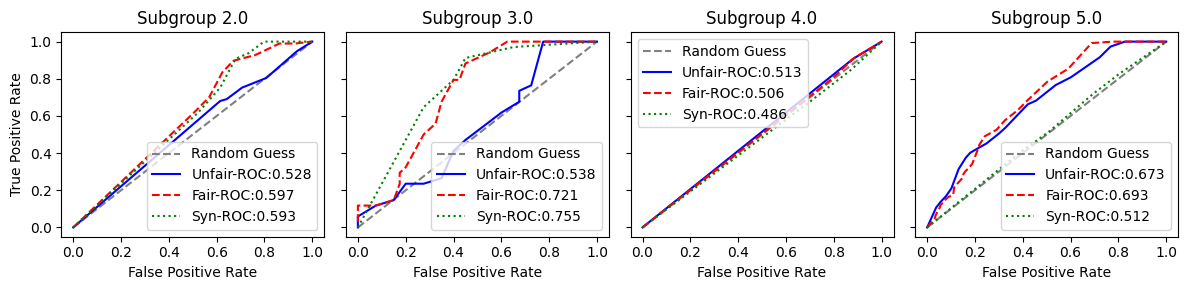

--------------------------------------------------------------------------------

fair_log deleted.
un_log deleted.
syn_log deleted.
RUN #2
GET UNIQUE INDICES REFERENCE
Number of train points: 3000
Number of test points: 3000
Number of fair train points: 5000
Number of population points: 10000
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
GET ORIGINAL MODEL
0.8996666666666666 sensitive_feature_0
0.0    0.733813
1.0    0.907725
Name: accuracy_score, dtype: float64
0.9433333333333334 sensitive_feature_0
0.0    0.840278
1.0    0.948529
Name: accuracy_score, dtype: float64
0.07656917765509269
GET FAIR MODEL
0.9003333333333333 sensitive_feature_0
0.0    0.733813
1.0    0.908424
Name: accuracy_score, dtype: float64
0.943 sensitive_feature_0
0.0    0.881944
1.0    0.946078
Name: accuracy_score, dtype: float64
0.13789524113701693
CREATE BINARY LABEL DATASET
   age  duration  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.0  0.013523  0.000376  0.187637       0.0

0.07669845325546382
GET MIA2 RESULTS
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
I

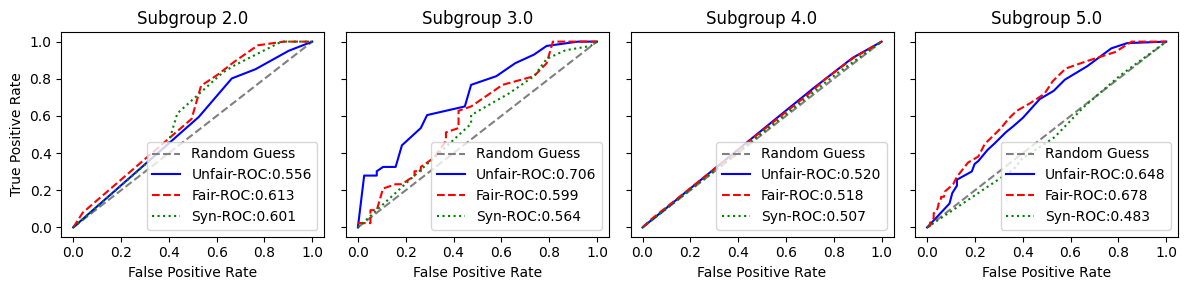

--------------------------------------------------------------------------------

fair_log deleted.
un_log deleted.
syn_log deleted.
RUN #3
GET UNIQUE INDICES REFERENCE
Number of train points: 3000
Number of test points: 3000
Number of fair train points: 5000
Number of population points: 10000
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
GET ORIGINAL MODEL
0.9063333333333333 sensitive_feature_0
0.0    0.787671
1.0    0.912404
Name: accuracy_score, dtype: float64
0.946 sensitive_feature_0
0.0    0.907801
1.0    0.947884
Name: accuracy_score, dtype: float64
0.16791979949874686
GET FAIR MODEL
0.9023333333333333 sensitive_feature_0
0.0    0.746575
1.0    0.910301
Name: accuracy_score, dtype: float64
0.946 sensitive_feature_0
0.0    0.865248
1.0    0.949983
Name: accuracy_score, dtype: float64
0.0639097744360902
CREATE BINARY LABEL DATASET
   age  duration  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.0  0.032854  0.000188  0.187550       0.0      0.000263

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
0.8606666666666667 sensitive_feature_0
0.0    0.712329
1.0    0.868255
Name: accuracy_score, dtype: float64
0.9416354556803995 sensitive_feature_0
0.0    0.898551
1.0    0.946835
Name: accuracy_score, dtype: float64
0.04887218045112782
GET MIA2 RESULTS
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR

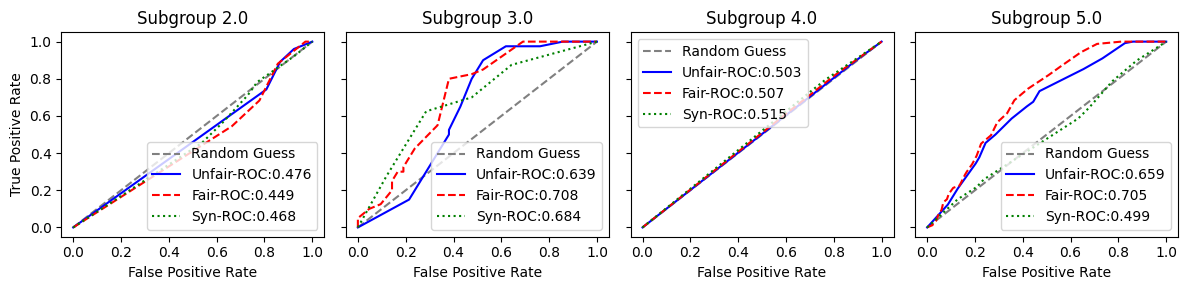

--------------------------------------------------------------------------------

fair_log deleted.
un_log deleted.
syn_log deleted.
RUN #4
GET UNIQUE INDICES REFERENCE
Number of train points: 3000
Number of test points: 3000
Number of fair train points: 5000
Number of population points: 10000
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
GET ORIGINAL MODEL
0.9086666666666666 sensitive_feature_0
0.0    0.790698
1.0    0.913967
Name: accuracy_score, dtype: float64
0.9436666666666667 sensitive_feature_0
0.0    0.801282
1.0    0.951477
Name: accuracy_score, dtype: float64
0.11110073487683808
GET FAIR MODEL
0.9043333333333333 sensitive_feature_0
0.0    0.790698
1.0    0.909439
Name: accuracy_score, dtype: float64
0.941 sensitive_feature_0
0.0    0.865385
1.0    0.945148
Name: accuracy_score, dtype: float64
0.0874129892893317
CREATE BINARY LABEL DATASET
   age  duration  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.0  0.072250  0.000566  0.188452       0.0 

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
0.8066666666666666 sensitive_feature_0
0.0    0.689922
1.0    0.811912
Name: accuracy_score, dtype: float64
0.9471214017521903 sensitive_feature_0
0.0    0.903409
1.0    0.952532
Name: accuracy_score, dtype: float64
0.14353804047210267
GET MIA2 RESULTS
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR

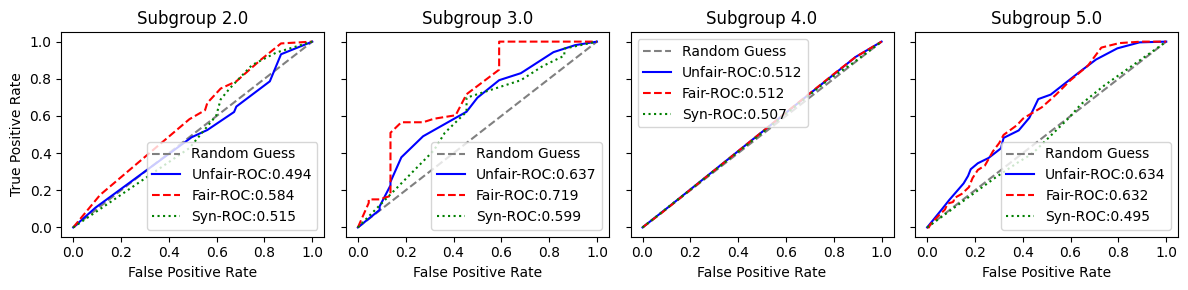

--------------------------------------------------------------------------------

fair_log deleted.
un_log deleted.
syn_log deleted.
RUN #5
GET UNIQUE INDICES REFERENCE
Number of train points: 3000
Number of test points: 3000
Number of fair train points: 5000
Number of population points: 10000
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
GET ORIGINAL MODEL
0.904 sensitive_feature_0
0.0    0.796875
1.0    0.908774
Name: accuracy_score, dtype: float64
0.9393333333333334 sensitive_feature_0
0.0    0.838235
1.0    0.944134
Name: accuracy_score, dtype: float64
0.1342062193126023
GET FAIR MODEL
0.8933333333333333 sensitive_feature_0
0.0    0.773438
1.0    0.898677
Name: accuracy_score, dtype: float64
0.9406666666666667 sensitive_feature_0
0.0    0.904412
1.0    0.942388
Name: accuracy_score, dtype: float64
0.07146753955264595
CREATE BINARY LABEL DATASET
   age  duration  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.0  0.087610  0.000565  0.188220       0.0 

0.7373333333333333 sensitive_feature_0
0.0    0.640625
1.0    0.741643
Name: accuracy_score, dtype: float64
0.9369007114135478 sensitive_feature_0
0.0    0.915989
1.0    0.939595
Name: accuracy_score, dtype: float64
0.15057283142389521
GET MIA2 RESULTS
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_outpu

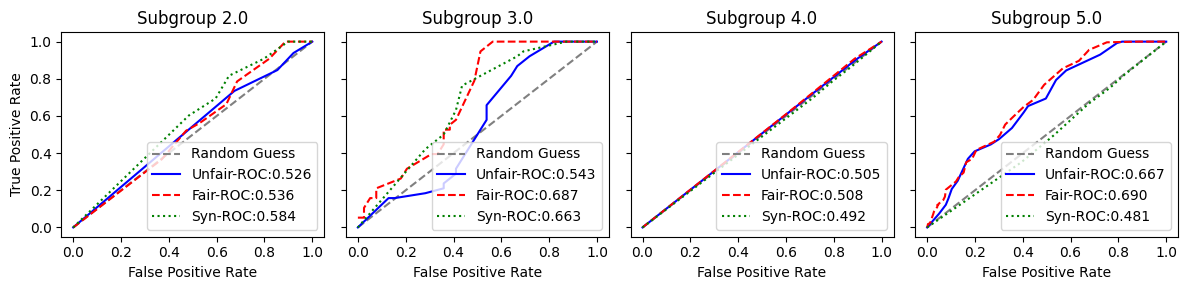

--------------------------------------------------------------------------------

fair_log deleted.
un_log deleted.
syn_log deleted.
RUN #6
GET UNIQUE INDICES REFERENCE
Number of train points: 3000
Number of test points: 3000
Number of fair train points: 5000
Number of population points: 10000
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
GET ORIGINAL MODEL
0.902 sensitive_feature_0
0.0    0.688406
1.0    0.912299
Name: accuracy_score, dtype: float64
0.9416666666666667 sensitive_feature_0
0.0    0.858108
1.0    0.946003
Name: accuracy_score, dtype: float64
0.16754465050779008
GET FAIR MODEL
0.902 sensitive_feature_0
0.0    0.746377
1.0    0.909504
Name: accuracy_score, dtype: float64
0.9396666666666667 sensitive_feature_0
0.0    0.898649
1.0    0.941795
Name: accuracy_score, dtype: float64
0.16618303571428572
CREATE BINARY LABEL DATASET
   age  duration  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.0  0.062803  0.000187  0.187283       0.0      0.00026

0.798 sensitive_feature_0
0.0    0.637681
1.0    0.805730
Name: accuracy_score, dtype: float64
0.9437229437229437 sensitive_feature_0
0.0    0.942408
1.0    0.943899
Name: accuracy_score, dtype: float64
0.15613839285714287
GET MIA2 RESULTS
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SO

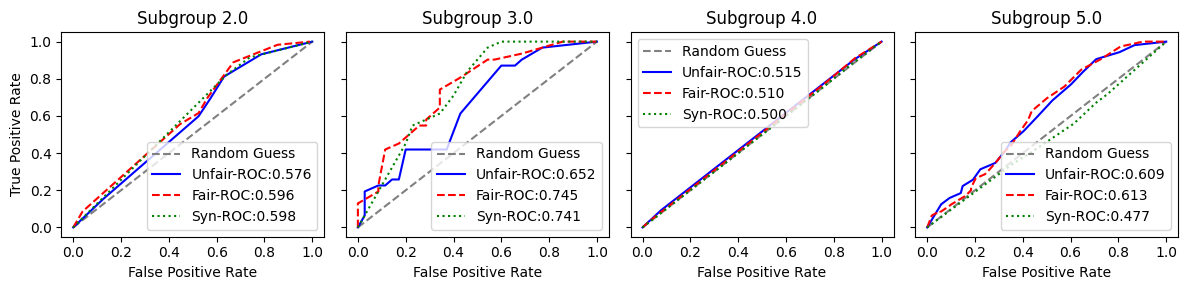

--------------------------------------------------------------------------------

fair_log deleted.
un_log deleted.
syn_log deleted.
RUN #7
GET UNIQUE INDICES REFERENCE
Number of train points: 3000
Number of test points: 3000
Number of fair train points: 5000
Number of population points: 10000
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
GET ORIGINAL MODEL
0.9093333333333333 sensitive_feature_0
0.0    0.742188
1.0    0.916783
Name: accuracy_score, dtype: float64
0.946 sensitive_feature_0
0.0    0.878505
1.0    0.948496
Name: accuracy_score, dtype: float64
0.10266306597543907
GET FAIR MODEL
0.9086666666666666 sensitive_feature_0
0.0    0.750000
1.0    0.915738
Name: accuracy_score, dtype: float64
0.9486666666666667 sensitive_feature_0
0.0    0.897196
1.0    0.950570
Name: accuracy_score, dtype: float64
0.08623524077979934
CREATE BINARY LABEL DATASET
   age  duration  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.0  0.057629  0.000576  0.191904       0.0

0.8253333333333334 sensitive_feature_0
0.0    0.726562
1.0    0.829735
Name: accuracy_score, dtype: float64
0.9483930778739185 sensitive_feature_0
0.0    0.953353
1.0    0.947805
Name: accuracy_score, dtype: float64
0.08491454928938913
GET MIA2 RESULTS
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_outpu

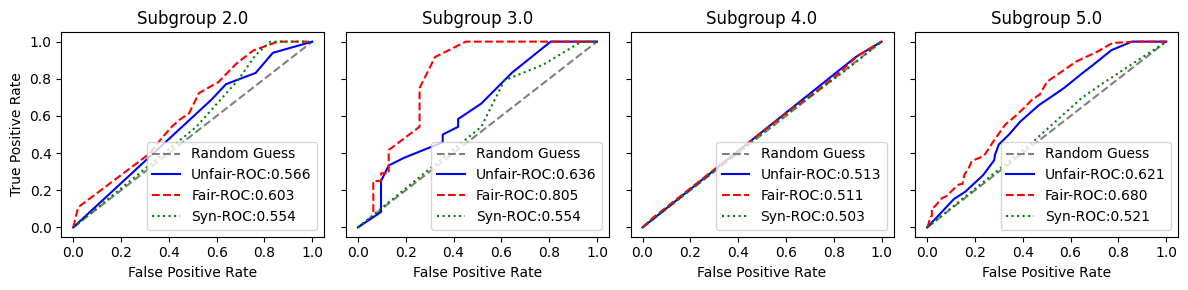

--------------------------------------------------------------------------------

fair_log deleted.
un_log deleted.
syn_log deleted.
RUN #8
GET UNIQUE INDICES REFERENCE
Number of train points: 3000
Number of test points: 3000
Number of fair train points: 5000
Number of population points: 10000
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
GET ORIGINAL MODEL
0.905 sensitive_feature_0
0.0    0.772727
1.0    0.911088
Name: accuracy_score, dtype: float64
0.9436666666666667 sensitive_feature_0
0.0    0.840580
1.0    0.948637
Name: accuracy_score, dtype: float64
0.09011040215242863
GET FAIR MODEL
0.9043333333333333 sensitive_feature_0
0.0    0.742424
1.0    0.911785
Name: accuracy_score, dtype: float64
0.9386666666666666 sensitive_feature_0
0.0    0.876812
1.0    0.941649
Name: accuracy_score, dtype: float64
0.1043758043758044
CREATE BINARY LABEL DATASET
   age  duration  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.0  0.110913  0.000191  0.191037       0.0 

0.852 sensitive_feature_0
0.0    0.727273
1.0    0.857741
Name: accuracy_score, dtype: float64
0.949569495694957 sensitive_feature_0
0.0    0.961538
1.0    0.947939
Name: accuracy_score, dtype: float64
0.091218932954554
GET MIA2 RESULTS
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURC

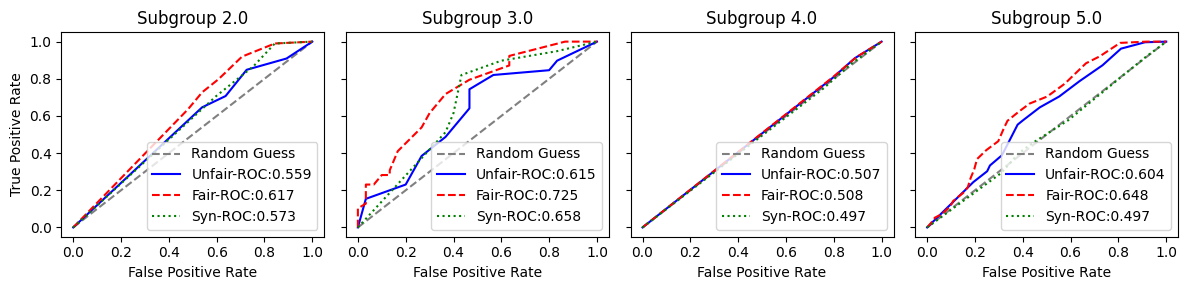

--------------------------------------------------------------------------------

fair_log deleted.
un_log deleted.
syn_log deleted.
RUN #9
GET UNIQUE INDICES REFERENCE
Number of train points: 3000
Number of test points: 3000
Number of fair train points: 5000
Number of population points: 10000
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
GET ORIGINAL MODEL
0.9003333333333333 sensitive_feature_0
0.0    0.802721
1.0    0.905363
Name: accuracy_score, dtype: float64
0.943 sensitive_feature_0
0.0    0.806723
1.0    0.948629
Name: accuracy_score, dtype: float64
0.09090909090909088
GET FAIR MODEL
0.9013333333333333 sensitive_feature_0
0.0    0.809524
1.0    0.906064
Name: accuracy_score, dtype: float64
0.943 sensitive_feature_0
0.0    0.890756
1.0    0.945158
Name: accuracy_score, dtype: float64
0.046875843454790816
CREATE BINARY LABEL DATASET
   age  duration  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.0  0.014045  0.000192  0.192204       0.0     -0.0003

0.816 sensitive_feature_0
0.0    0.659864
1.0    0.824045
Name: accuracy_score, dtype: float64
0.9451294697903823 sensitive_feature_0
0.0    0.922865
1.0    0.947935
Name: accuracy_score, dtype: float64
0.14831983805668017
GET MIA2 RESULTS
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SO

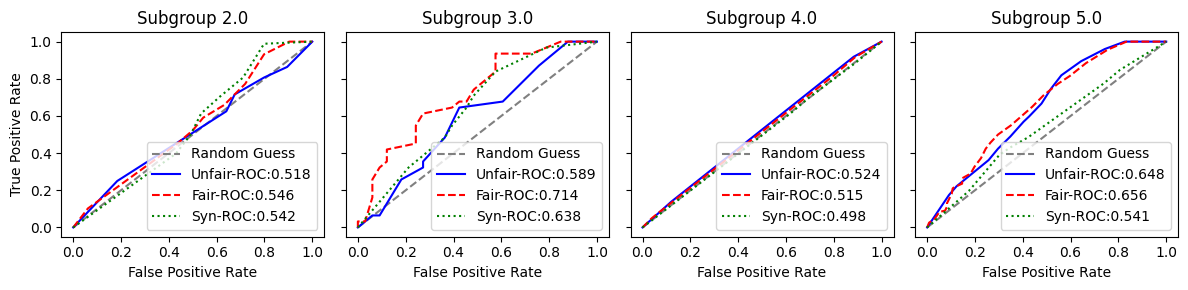

--------------------------------------------------------------------------------

fair_log deleted.
un_log deleted.
syn_log deleted.
RUN #10
GET UNIQUE INDICES REFERENCE
Number of train points: 3000
Number of test points: 3000
Number of fair train points: 5000
Number of population points: 10000
DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
GET ORIGINAL MODEL
0.8936666666666667 sensitive_feature_0
0.0    0.721805
1.0    0.901639
Name: accuracy_score, dtype: float64
0.943 sensitive_feature_0
0.0    0.866667
1.0    0.946181
Name: accuracy_score, dtype: float64
0.10018867294463366
GET FAIR MODEL
0.893 sensitive_feature_0
0.0    0.714286
1.0    0.901291
Name: accuracy_score, dtype: float64
0.94 sensitive_feature_0
0.0    0.866667
1.0    0.943056
Name: accuracy_score, dtype: float64
0.09436569157817404
CREATE BINARY LABEL DATASET
   age  duration  campaign     pdays  previous  emp.var.rate  cons.price.idx  \
0  1.0  0.016716  0.000376  0.187627       0.0      0.000263        0.01

0.2485395189003437
GET MIA2 RESULTS
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'test', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'test', '<default_group>')]
INFO SOURCE MAPPING OBJ FOR GROUP:  [(0, 'train', '<default_group>')]
IN

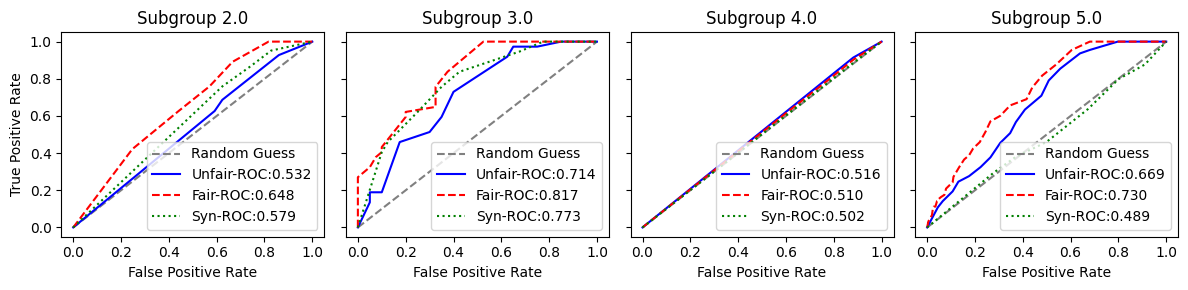

--------------------------------------------------------------------------------

fair_log deleted.
un_log deleted.
syn_log deleted.


In [57]:
all_results = []

for i in range(10):
    print("==============================================================")
    print(f"RUN #{i + 1}")
    run_results = run_mia2_attack()
    all_results.append(run_results)
    print("==============================================================")

In [58]:
# Debugging: Print all_results after all runs
print(f"Number of results collected: {len(all_results)}")
print(all_results)

Number of results collected: 10
[{'privacy_risks': {2.0: {'unfair': 0.5, 'fair': 0.6135912229263218, 'synthetic': 0.6141587061382767}, 3.0: {'unfair': 0.6125, 'fair': 0.7161764705882353, 'synthetic': 0.7308823529411765}, 4.0: {'unfair': 0.5133755977738487, 'fair': 0.5133465990672949, 'synthetic': 0.5}, 5.0: {'unfair': 0.6208913087315991, 'fair': 0.652183619969464, 'synthetic': 0.512372886238585}}, 'auc_scores': {2.0: {'unfair': 0.5279958384564456, 'fair': 0.5971815000472903, 'synthetic': 0.5927835051546392}, 3.0: {'unfair': 0.538235294117647, 'fair': 0.7205882352941176, 'synthetic': 0.7547794117647059}, 4.0: {'unfair': 0.5133755977738487, 'fair': 0.5058867374304328, 'synthetic': 0.48633767844216874}, 5.0: {'unfair': 0.6733644455967506, 'fair': 0.693306542217613, 'synthetic': 0.5119479733817303}}}, {'privacy_risks': {2.0: {'unfair': 0.5693069306930694, 'fair': 0.6138613861386139, 'synthetic': 0.6039603960396039}, 3.0: {'unfair': 0.6575887392900857, 'fair': 0.5921052631578947, 'synthetic

In [59]:
# Extract Privacy Risk and AUC scores
privacy_risk_data = []
auc_data = []

for i, result in enumerate(all_results):
    print(f"Current run index (i): {i}")
    for group in result["privacy_risks"]:
        privacy_risk_data.append({
            "Run": i + 1,
            "Group": group,
            "Unfair PR": result["privacy_risks"][group]["unfair"],
            "Fair PR": result["privacy_risks"][group]["fair"],
            "Synthetic PR": result["privacy_risks"][group]["synthetic"]
        })
        
        
        auc_data.append({
            "Run": i + 1,
            "Group": group,
            "Unfair AUC": result["auc_scores"][group]["unfair"],
            "Fair AUC": result["auc_scores"][group]["fair"],
            "Synthetic AUC": result["auc_scores"][group]["synthetic"]
        })
        
    print("PRIVACY RISK DATA:", privacy_risk_data)
    print("AUC DATA:", auc_data)

# Convert to DataFrame
pr_df = pd.DataFrame(privacy_risk_data)
auc_df = pd.DataFrame(auc_data)

# Calculate Mean and Standard Deviation
pr_mean_std = pr_df.groupby("Group")[["Unfair PR", "Fair PR", "Synthetic PR"]].agg(['mean', 'std'])
auc_mean_std = auc_df.groupby("Group")[["Unfair AUC", "Fair AUC", "Synthetic AUC"]].agg(['mean', 'std'])

# Display Results
print("Privacy Risk (Mean and Std):")
print(pr_mean_std)

print("\nAUC Scores (Mean and Std):")
print(auc_mean_std)

Current run index (i): 0
PRIVACY RISK DATA: [{'Run': 1, 'Group': 2.0, 'Unfair PR': 0.5, 'Fair PR': 0.6135912229263218, 'Synthetic PR': 0.6141587061382767}, {'Run': 1, 'Group': 3.0, 'Unfair PR': 0.6125, 'Fair PR': 0.7161764705882353, 'Synthetic PR': 0.7308823529411765}, {'Run': 1, 'Group': 4.0, 'Unfair PR': 0.5133755977738487, 'Fair PR': 0.5133465990672949, 'Synthetic PR': 0.5}, {'Run': 1, 'Group': 5.0, 'Unfair PR': 0.6208913087315991, 'Fair PR': 0.652183619969464, 'Synthetic PR': 0.512372886238585}]
AUC DATA: [{'Run': 1, 'Group': 2.0, 'Unfair AUC': 0.5279958384564456, 'Fair AUC': 0.5971815000472903, 'Synthetic AUC': 0.5927835051546392}, {'Run': 1, 'Group': 3.0, 'Unfair AUC': 0.538235294117647, 'Fair AUC': 0.7205882352941176, 'Synthetic AUC': 0.7547794117647059}, {'Run': 1, 'Group': 4.0, 'Unfair AUC': 0.5133755977738487, 'Fair AUC': 0.5058867374304328, 'Synthetic AUC': 0.48633767844216874}, {'Run': 1, 'Group': 5.0, 'Unfair AUC': 0.6733644455967506, 'Fair AUC': 0.693306542217613, 'Synthe

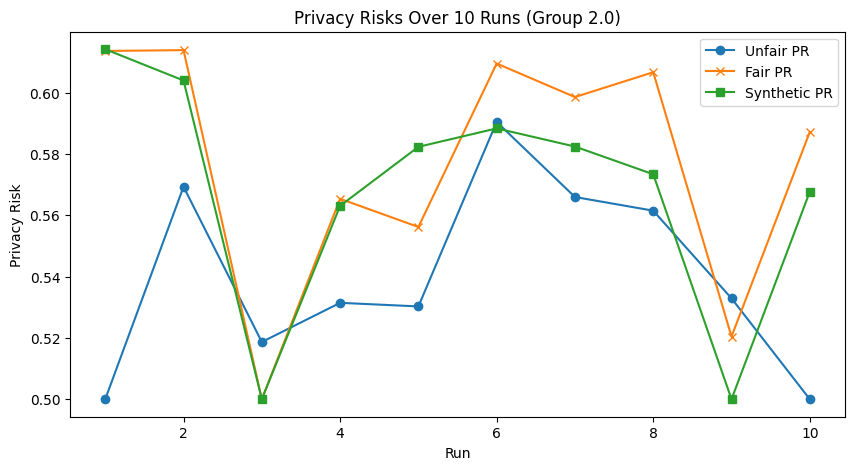

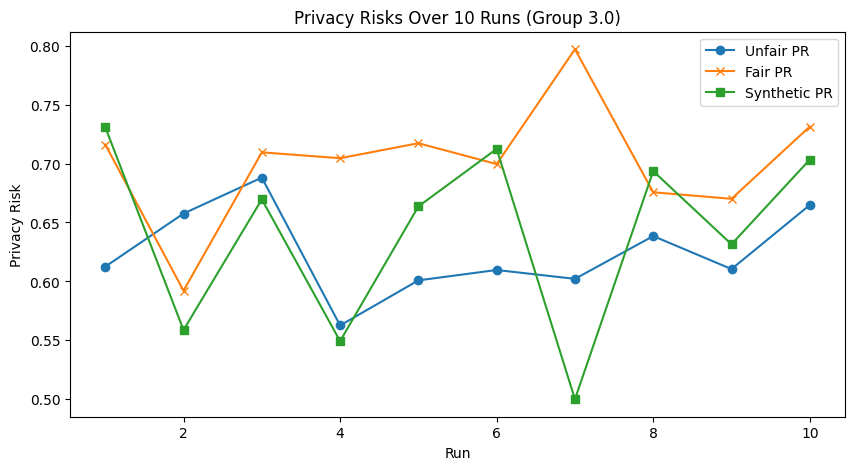

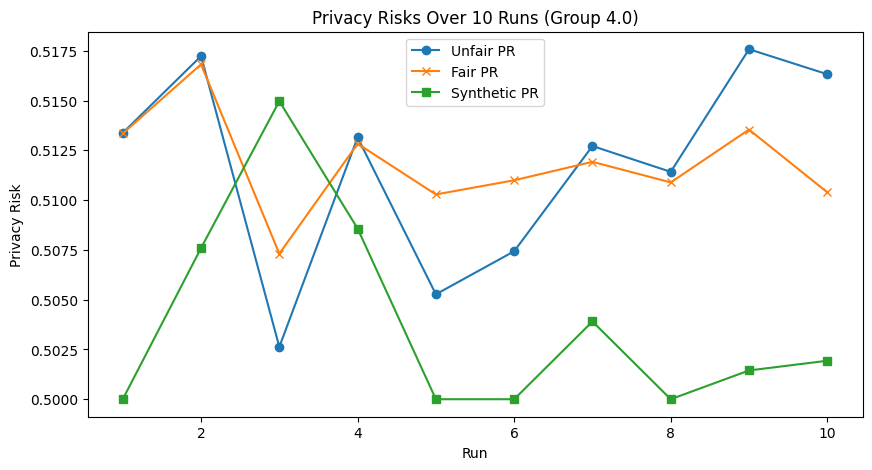

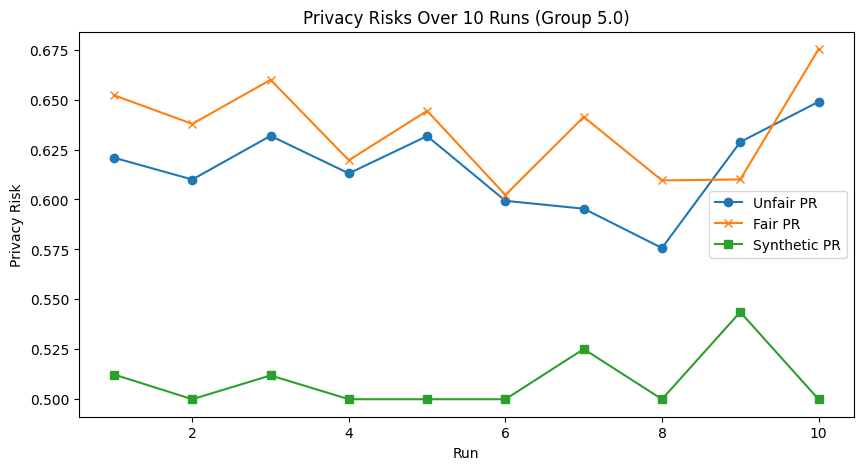

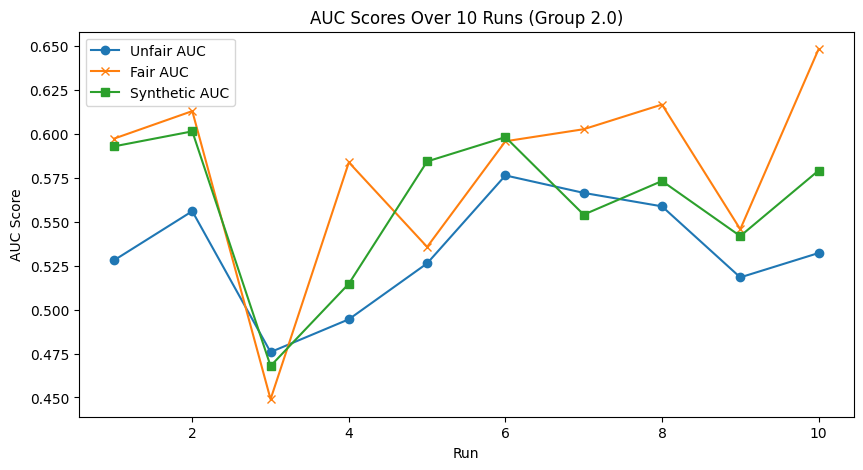

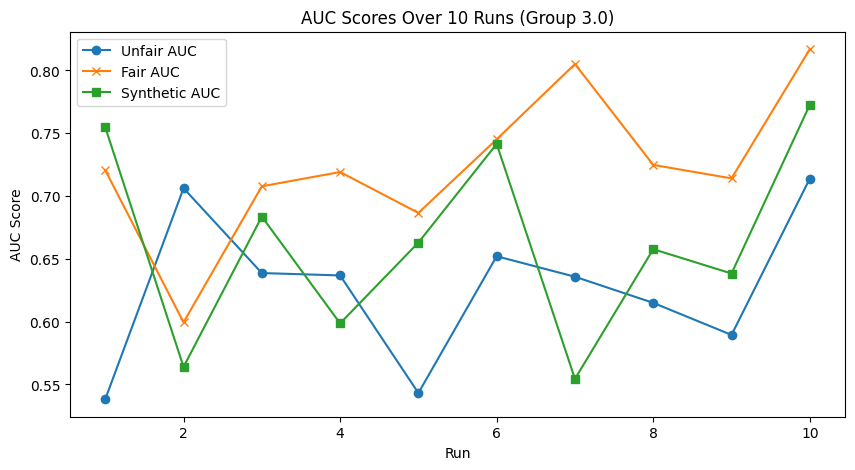

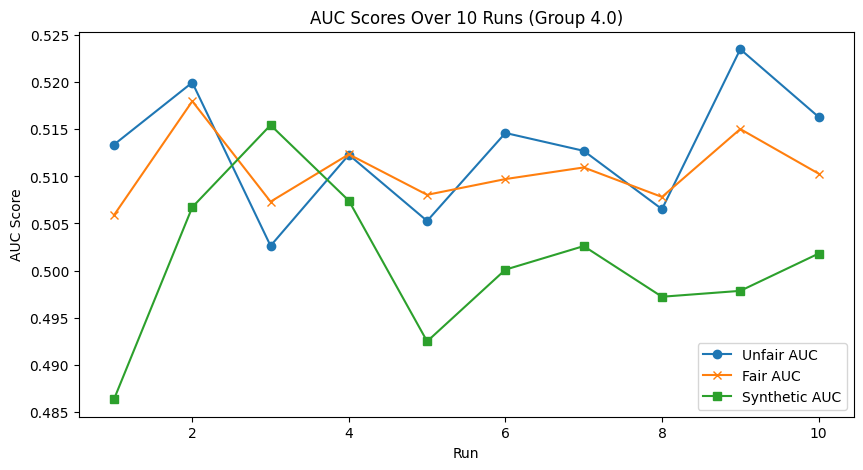

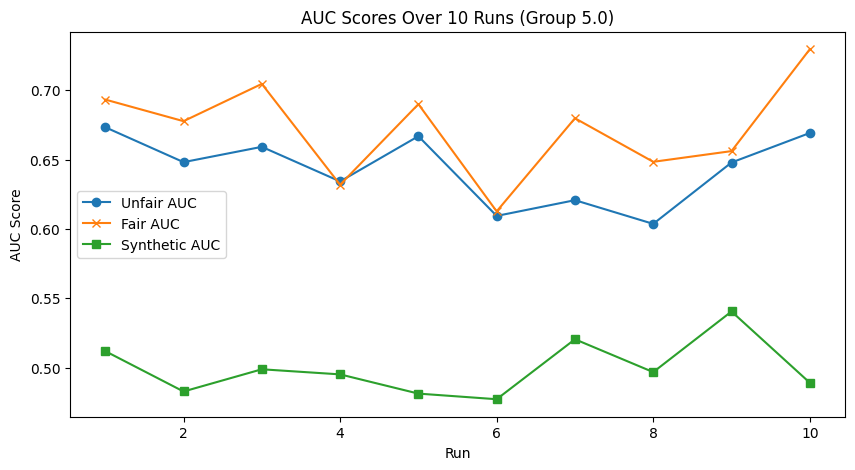

In [60]:
import matplotlib.pyplot as plt

# Plot Privacy Risks
for group in pr_df["Group"].unique():
    group_data = pr_df[pr_df["Group"] == group]
    plt.figure(figsize=(10, 5))
    plt.plot(group_data["Run"], group_data["Unfair PR"], label="Unfair PR", marker="o")
    plt.plot(group_data["Run"], group_data["Fair PR"], label="Fair PR", marker="x")
    plt.plot(group_data["Run"], group_data["Synthetic PR"], label="Synthetic PR", marker="s")
    plt.title(f"Privacy Risks Over 10 Runs (Group {group})")
    plt.xlabel("Run")
    plt.ylabel("Privacy Risk")
    plt.legend()
    plt.show()

# Plot AUC Scores
for group in auc_df["Group"].unique():
    group_data = auc_df[auc_df["Group"] == group]
    plt.figure(figsize=(10, 5))
    plt.plot(group_data["Run"], group_data["Unfair AUC"], label="Unfair AUC", marker="o")
    plt.plot(group_data["Run"], group_data["Fair AUC"], label="Fair AUC", marker="x")
    plt.plot(group_data["Run"], group_data["Synthetic AUC"], label="Synthetic AUC", marker="s")
    plt.title(f"AUC Scores Over 10 Runs (Group {group})")
    plt.xlabel("Run")
    plt.ylabel("AUC Score")
    plt.legend()
    plt.show()

In [61]:
# Calculate Mean Privacy Risks
mean_pr = pr_df.groupby("Group")[["Unfair PR", "Fair PR", "Synthetic PR"]].mean()
print("Mean Privacy Risks:")
print(mean_pr)

# Calculate Mean AUC Scores
mean_auc = auc_df.groupby("Group")[["Unfair AUC", "Fair AUC", "Synthetic AUC"]].mean()
print("Mean AUC Scores:")
print(mean_auc)

Mean Privacy Risks:
       Unfair PR   Fair PR  Synthetic PR
Group                                   
2.0     0.540047  0.577134      0.567532
3.0     0.624728  0.701336      0.641311
4.0     0.511712  0.511833      0.503841
5.0     0.615554  0.635222      0.509305
Mean AUC Scores:
       Unfair AUC  Fair AUC  Synthetic AUC
Group                                     
2.0      0.533214  0.578677       0.560681
3.0      0.626922  0.723950       0.662850
4.0      0.512722  0.510540       0.500799
5.0      0.643300  0.672428       0.499446


# Different approach for PR, AUC, and ROC

# Prepare for next run